<a href="https://colab.research.google.com/github/SadhnaBijrothiya/DL/blob/main/DataCode_TM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import sys
import numpy
import xlrd
import pandas as pd
import os
import matplotlib.pyplot as plt
import io
import math
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from scipy.signal import savgol_filter
from scipy import signal
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
# Create the LSTM model
from tensorflow import keras, convert_to_tensor, float32, make_ndarray
from tensorflow.compat.v1 import Session
from tensorflow.keras import layers, backend
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, GlobalAveragePooling1D, Dropout
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, MaxPool1D, TimeDistributed, RepeatVector
from keras.layers.merge import concatenate
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import random

# Create the LSTM model

In [ ]:
from tensorflow import keras, convert_to_tensor, float32, make_ndarray
from tensorflow.compat.v1 import Session
from tensorflow.keras import layers, backend
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, GlobalAveragePooling1D, Dropout
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, MaxPool1D, TimeDistributed, RepeatVector
from keras.layers.merge import concatenate
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving WBDS01walkT01ang.txt to WBDS01walkT01ang (5).txt


In [ ]:
def plotData(person, speed):
  ini_name = "/content/" 
  name ='WBDS' + ("" if person > 9 else "0") + str(person) + 'walkT' + "0" + str(speed)
  data = pd.read_csv(ini_name + name + 'ang.txt', delimiter = "\t")
  plt.plot(data['LKneeAngleZ'], label='Left Knee')
  plt.plot(data['LAnkleAngleZ'], label='Left Ankle')
  plt.plot(data['LHipAngleZ'], label='Left Hip')
  plt.ylabel("Angle")
  plt.xlabel("Time Steps")
  plt.legend()
  plt.show()
  print(data)

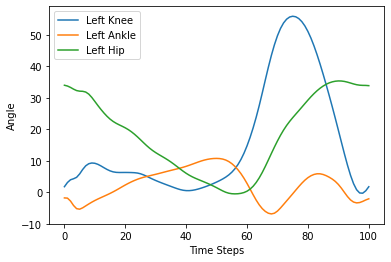

     Time  RPelvisAngleX  RPelvisAngleY  ...  LFootAngleX  LFootAngleY  LFootAngleZ
0       0        1.22974        3.19707  ...    -2.124730      11.2090     13.81770
1       1        1.17795        3.51900  ...    -1.846750      10.9443     12.29670
2       2        1.19296        3.83525  ...    -1.384440      10.9343     10.23790
3       3        1.29748        4.08656  ...    -0.723330      11.2620      8.11868
4       4        1.47220        4.22469  ...    -0.113339      11.6319      6.31756
..    ...            ...            ...  ...          ...          ...          ...
96     96        1.57769        1.91211  ...    -2.256570      12.2840     13.26760
97     97        1.51078        2.16201  ...    -2.532170      11.8276     14.23700
98     98        1.42465        2.41361  ...    -2.555830      11.5935     14.65520
99     99        1.32950        2.67979  ...    -2.401180      11.4240     14.42270
100   100        1.24176        2.97269  ...    -2.170350      11.1904     1

In [ ]:
plotData(1,2)

In [ ]:
personalData = pd.read_excel(r"/content/WBDSinfo.xlsx", engine='openpyxl')

In [ ]:
personalData

,Subject,FileName,AgeGroup,Age,Height,Mass,Gender,Dominance,LegLength,Static1,Static2,GaitSpeed(m/s),TreadHands,FP_RightFoot,FP_LeftFoot,Notes,BorgScale,Unnamed: 17
0,1,WBDS01static1.c3d,Young,25,172.5,74.30,M,R,0.89,Yes,No,--,--,--,--,--,10.0,NaN
1,1,WBDS01walkT01.c3d,Young,25,172.5,74.30,M,R,0.89,Yes,No,0.49,No,--,--,--,10.0,NaN
2,1,WBDS01walkT02.c3d,Young,25,172.5,74.30,M,R,0.89,Yes,No,0.67,No,--,--,--,10.0,NaN
3,1,WBDS01walkT03.c3d,Young,25,172.5,74.30,M,R,0.89,Yes,No,0.85,No,--,--,--,10.0,NaN
4,1,WBDS01walkT04.c3d,Young,25,172.5,74.30,M,R,0.89,Yes,No,1.03,No,--,--,--,10.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6910,42,WBDS42walkT06knt.txt,Older,63,161.2,59.85,F,R,0.82,--,--,--,--,--,--,--,9.0,NaN
6911,42,WBDS42walkT07ang.txt,Older,63,161.2,59.85,F,R,0.82,--,--,--,--,--,--,--,9.0,NaN
6912,42,WBDS42walkT07knt.txt,Older,63,161.2,59.85,F,R,0.82,--,--,--,--,--,--,--,9.0,NaN
6913,42,WBDS42walkT08ang.txt,Older,63,161.2,59.85,F,R,0.82,--,--,--,--,--,--,--,9.0,NaN


In [ ]:
filter = personalData["FileName"]=="WBDS01walkT01.c3d"

# filtering data 

In [ ]:
dt = personalData.loc[filter]

# display

In [ ]:
dt.iloc[0]['Age']

25

In [ ]:
def todot(a,dt):
  x=len(a)
  b=numpy.zeros(a.shape)
  b[0]=a[0]/dt
  for i in range(1,x):
    b[i]=(a[i]-a[i-1])/dt
  return b

In [ ]:
def plotDot(jointAngle, jointAngleDot, time):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca(projection='3d')
  z = numpy.linspace(0, time/100, time - 1)
  ax.plot(jointAngle, jointAngleDot, z)
  ax.set_xlabel("joint angle")
  ax.set_ylabel("angular velocity")
  plt.show()

In [ ]:
def custom_loss(y_true, y_pred):
                                       # print(y_true[0][0], y_pred[0][0])
  initial = []
  rmse = 0
  n = len(y_true)
  ty = y_true[:, 100]
  py = y_pred[:, 0]
  return (backend.mean(backend.square(y_pred - y_true)) / 101)

In [ ]:
def build_lstm(time_steps, features):
  model = Sequential() #sequential model
  model.add(LSTM(100, input_shape=(time_steps, features), return_sequences=False))
  # model.add(RepeatVector(3))
  model.add(Dense(50, activation='relu'))
  # model.add(Dense(50, activation='relu'))
  model.add(Dense(time_steps, activation='linear'))
  model.compile(optimizer='adam', loss=custom_loss,metrics=['accuracy'])
  model.summary()
  return model

#CNN model

In [ ]:
def build_cnn(time_steps, features):
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_steps, features)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(time_steps, activation='linear'))
  model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])
  print(model.summary())
  return model

#CNN_GRU model implementation

In [ ]:
def build_cnn_gru(time_steps, features):
  input = keras.Input(shape=(time_steps, features))
  convModel = Conv1D(filters=64, kernel_size=2, activation='relu')(input)
  # convModel = Dropout(0.2)(convModel)
  convModel = MaxPooling1D(pool_size=2)(convModel)
  convModel = Conv1D(filters=64, kernel_size=2, activation='relu')(convModel)
  convModel = MaxPooling1D(pool_size=2)(convModel)
  # convModel = Dropout(0.2)(convModel)
  convModel = Flatten()(convModel)

  ##second conv model
  convModel2 = Conv1D(filters=64, kernel_size=2, activation='relu')(input)
  # convModel = Dropout(0.2)(convModel)
  convModel2 = MaxPooling1D(pool_size=2)(convModel2)
  convModel2 = Conv1D(filters=64, kernel_size=2, activation='relu')(convModel2)
  convModel2 = MaxPooling1D(pool_size=2)(convModel2)
  convModel2 = Conv1D(filters=64, kernel_size=2, activation='relu')(convModel2)
  convModel2 = MaxPooling1D(pool_size=2)(convModel2)
  # convModel = Dropout(0.2)(convModel)
  convModel2 = Flatten()(convModel2)

  gruModel = GRU(100, return_sequences=False)(input)

  merge = concatenate([convModel, convModel2, gruModel])
  # merge = GlobalAveragePooling1D()(merge)

  hidden1 = Dense(time_steps, activation='relu')(merge)
  output = Dense(time_steps, activation='linear')(hidden1)
  # output = GlobalAveragePooling1D()(hidden1)

  model = Model(inputs=input, outputs=output)
  print(model.summary())
  model.compile(
      optimizer='adam',
      loss=custom_loss,
      metrics=['accuracy']
  )
  return model

In [ ]:
def modelPlot(model, name):
  plot_model(model, to_file=name+'.png', show_shapes=True)

In [ ]:
build_lstm(101, 7)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               43200     
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 101)               5151      
Total params: 53,401
Trainable params: 53,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
temp = pd.read_csv('/content/WBDS02walkT01ang.txt')

In [ ]:
#multivariate time series
#WBDS01walkT01.c3d
#hip = 0, knee = 1, ankle = 2
#input => [Age, Height, Mass, Gender, GaitSpeed, LegLength, Dominance, jointNumber]
#outputShape = 101 * 3 (hip, knee, ankle)
person1_x = []
person1_y = []
person2_x = []
person2_y = []
hip_test_x = []
ankle_test_x = []
knee_test_x = []
hip_test_y = []
ankle_test_y = []
knee_test_y = []
personal_information = []
def dataPrep():
  train_x, train_y, test_x, test_y = [], [], [], []
  prev = -1
  for i in range(1, 43):
    flagPerson = 0
    curr = random.randint(1, 8)
    for j in range(1, 9):
      temp_x = []
      # temp_y = []
      ini_name = "/content/" 
      name ='WBDS' + ("" if i > 9 else "0") + str(i) + 'walkT' + "0" + str(j)
      filter = personalData["FileName"]==name + ".c3d"
      dt = personalData.loc[filter]
      if flagPerson == 0:
        flagPerson = 1
        personal_information.append([dt.iloc[0]['Age'], dt.iloc[0]['Height'], dt.iloc[0]['Mass'], 
                          dt.iloc[0]['GaitSpeed(m/s)'], dt.iloc[0]['LegLength']])
      try:
        data = pd.read_csv(ini_name + name + 'ang.txt', delimiter = "\t")
        for joint in range(3):
          temp_x = []
          for _ in range(101):
            temp_x.append([dt.iloc[0]['Age'], dt.iloc[0]['Height'], dt.iloc[0]['Mass'], (0 if dt.iloc[0]['Gender'] == 'M' else 1), 
                          dt.iloc[0]['GaitSpeed(m/s)'], dt.iloc[0]['LegLength'], joint])
            
          if i == 1:
            person1_x.append(temp_x.copy())
          if i == 2:
            person2_x.append(temp_x.copy())
            
          if curr != j:
            # print("train =>", i, j)
            train_x.append(temp_x.copy())
            # train_y.append(temp_y.copy())
          else:
            test_x.append(temp_x.copy())

            if joint == 0:
              hip_test_x.append(temp_x.copy())
              hip_test_y.append(data['LHipAngleZ'])
            
            elif joint  == 1:
              knee_test_x.append(temp_x.copy())
              knee_test_y.append(data['LKneeAngleZ'])
            
            else:
              ankle_test_x.append(temp_x.copy())
              ankle_test_y.append(data['LAnkleAngleZ'])

        if curr != j:
          # train_y.append(temp_y.copy())
          train_y.append(data['LHipAngleZ'])
          train_y.append(data['LKneeAngleZ'])
          train_y.append(data['LAnkleAngleZ'])
        else:
          # test_y.append(temp_y.copy())
          test_y.append(data['LHipAngleZ'])
          test_y.append(data['LKneeAngleZ'])
          test_y.append(data['LAnkleAngleZ'])
        if i == 1:
          person1_y.append(data['LHipAngleZ'])
          person1_y.append(data['LKneeAngleZ'])
          person1_y.append(data['LAnkleAngleZ'])
        if i == 2:
          person2_y.append(data['LHipAngleZ'])
          person2_y.append(data['LKneeAngleZ'])
          person2_y.append(data['LAnkleAngleZ'])
      except:
        # print(str(e))
        continue
    
  train_x = numpy.array(train_x)
  train_y = numpy.array(train_y)
  test_x = numpy.array(test_x)
  test_y = numpy.array(test_y)

  return train_x, train_y, test_x, test_y

In [ ]:
train_x, train_y, test_x, test_y = dataPrep()

In [ ]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((864, 101, 7), (864, 101), (120, 101, 7), (120, 101))

In [ ]:
hip_test_x = numpy.array(hip_test_x)
ankle_test_x = numpy.array(ankle_test_x)
knee_test_x = numpy.array(knee_test_x)
hip_test_y = numpy.array(hip_test_y)
ankle_test_y = numpy.array(ankle_test_y)
knee_test_y = numpy.array(knee_test_y)

In [ ]:
hip_test_x.shape, hip_test_y.shape

((40, 101, 7), (40, 101))

In [ ]:
knee_test_x.shape, knee_test_y.shape

((40, 101, 7), (40, 101))

In [ ]:
ankle_test_x.shape, ankle_test_y.shape

((40, 101, 7), (40, 101))

In [ ]:
#Age, Height, Mass, Speed, LegLength
personal_information = numpy.array(personal_information)
personal_std = numpy.std(personal_information, axis=0)
personal_mean = numpy.mean(personal_information, axis=0)
personal_max = numpy.max(personal_information, 0)
personal_min = numpy.min(personal_information, 0)

In [ ]:
personal_std

array([18.40396105, 10.88214435, 11.1080263 ,  0.06325317,  0.06654711])

In [ ]:
personal_mean

array([ 42.64285714, 167.11904762,  67.76428571,   0.49880952,
         0.86089286])

In [ ]:
personal_min

array([ 21.  , 147.  ,  44.9 ,   0.36,   0.71])

In [ ]:
personal_max

array([ 84.  , 192.  ,  95.4 ,   0.61,   0.98])

In [ ]:
person1_x = numpy.array(person1_x)
person1_y = numpy.array(person1_y)
person2_x = numpy.array(person2_x)
person2_y = numpy.array(person2_y)

In [ ]:
person1_x.shape, person1_y.shape

((24, 101, 7), (24, 101))

In [ ]:
lstm_model = build_lstm(101, 7)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               43200     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 101)               5151      
Total params: 53,401
Trainable params: 53,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelPlot(lstm_model, 'lstm_model')

In [ ]:
lstm_model_history = lstm_model.fit(train_x, train_y, epochs=200)

Epoch 1/200
27/27 [==============================] - 3s 56ms/step - loss: 4.4633 - accuracy: 0.0120
Epoch 2/200
27/27 [==============================] - 1s 55ms/step - loss: 4.0619 - accuracy: 0.0052
Epoch 3/200
27/27 [==============================] - 1s 54ms/step - loss: 3.2358 - accuracy: 0.0073
Epoch 4/200
27/27 [==============================] - 1s 55ms/step - loss: 2.5397 - accuracy: 0.0059
Epoch 5/200
27/27 [==============================] - 1s 54ms/step - loss: 2.3100 - accuracy: 0.0084
Epoch 6/200
27/27 [==============================] - 2s 56ms/step - loss: 2.2403 - accuracy: 0.0024
Epoch 7/200
27/27 [==============================] - 1s 54ms/step - loss: 2.2326 - accuracy: 0.0000e+00
Epoch 8/200
27/27 [==============================] - 1s 54ms/step - loss: 2.2581 - accuracy: 0.0000e+00
Epoch 9/200
27/27 [==============================] - 1s 54ms/step - loss: 2.2742 - accuracy: 0.0000e+00
Epoch 10/200
27/27 [==============================] - 1s 55ms/step - loss: 2.1975 - accu

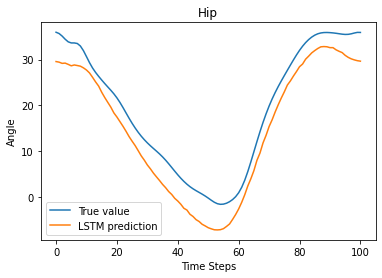

In [ ]:
plt.plot(test_y[0], label='True value')
plt.plot(lstm_model.predict(test_x)[0], label='LSTM prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Hip")
plt.legend()
plt.show()

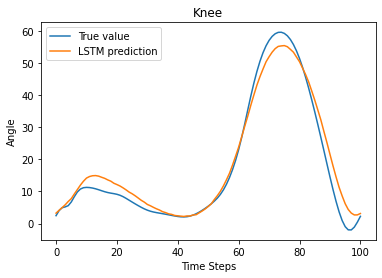

In [ ]:
plt.plot(test_y[1], label='True value')
plt.plot(lstm_model.predict(test_x)[1], label='LSTM prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Knee")
plt.legend()
plt.show()

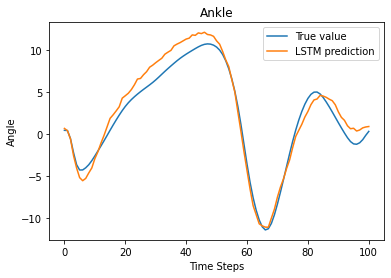

In [ ]:
plt.plot(test_y[2], label='True value')
plt.plot(lstm_model.predict(test_x)[2], label='LSTM prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Ankle")
plt.legend()
plt.show()

In [ ]:
cnn_model = build_cnn(101, 7)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 100, 64)           960       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                160050    
_________________________________________________________________
dense_5 (Dense)              (None, 101)               5151      
Total params: 166,161
Trainable params: 166,161
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
modelPlot(cnn_model, 'cnn_model')

In [58]:
cnn_model_history = cnn_model.fit(train_x, train_y, epochs=300)

Epoch 1/300
27/27 [==============================] - 0s 7ms/step - loss: 2.4941 - accuracy: 0.0058
Epoch 2/300
27/27 [==============================] - 0s 6ms/step - loss: 2.4930 - accuracy: 0.0058
Epoch 3/300
27/27 [==============================] - 0s 6ms/step - loss: 2.4919 - accuracy: 0.0058
Epoch 4/300
27/27 [==============================] - 0s 7ms/step - loss: 2.4907 - accuracy: 0.0058
Epoch 5/300
27/27 [==============================] - 0s 7ms/step - loss: 2.4896 - accuracy: 0.0058
Epoch 6/300
27/27 [==============================] - 0s 6ms/step - loss: 2.4885 - accuracy: 0.0058
Epoch 7/300
27/27 [==============================] - 0s 7ms/step - loss: 2.4874 - accuracy: 0.0058
Epoch 8/300
27/27 [==============================] - 0s 6ms/step - loss: 2.4862 - accuracy: 0.0058
Epoch 9/300
27/27 [==============================] - 0s 6ms/step - loss: 2.4851 - accuracy: 0.0058
Epoch 10/300
27/27 [==============================] - 0s 6ms/step - loss: 2.4840 - accuracy: 0.0058
Epoch 11/

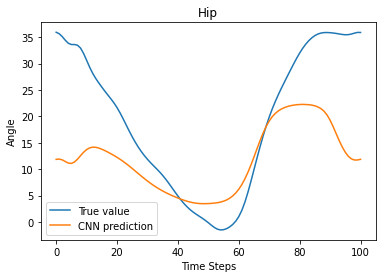

In [59]:
plt.plot(test_y[0], label='True value')
plt.plot(cnn_model.predict(test_x)[0], label='CNN prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Hip")
plt.legend()
plt.show()

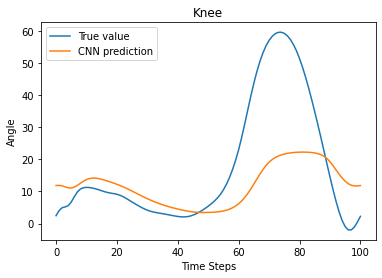

In [60]:
plt.plot(test_y[1], label='True value')
plt.plot(cnn_model.predict(test_x)[1], label='CNN prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Knee")
plt.legend()
plt.show()

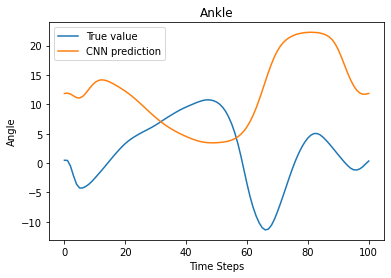

In [61]:
plt.plot(test_y[2], label='True value')
plt.plot(cnn_model.predict(test_x)[2], label='CNN prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Ankle")
plt.legend()
plt.show()

In [62]:
cnn_gru_model = build_cnn_gru(101, 7)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 101, 7)]     0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 100, 64)      960         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)  (None, 50, 64)       0           conv1d_3[0][0]                   
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 64)      960         input_1[0][0]                    
______________________________________________________________________________________________

In [63]:
modelPlot(cnn_gru_model, "cnn_gru_model2")

In [64]:
cnn_gru_history = cnn_gru_model.fit(train_x, train_y, epochs=300)

Epoch 1/300
27/27 [==============================] - 3s 59ms/step - loss: 4.6235 - accuracy: 0.0183
Epoch 2/300
27/27 [==============================] - 2s 58ms/step - loss: 2.7591 - accuracy: 0.0821
Epoch 3/300
27/27 [==============================] - 2s 58ms/step - loss: 2.3662 - accuracy: 0.0058
Epoch 4/300
27/27 [==============================] - 2s 58ms/step - loss: 2.1939 - accuracy: 0.0050
Epoch 5/300
27/27 [==============================] - 2s 58ms/step - loss: 2.2638 - accuracy: 8.3216e-04
Epoch 6/300
27/27 [==============================] - 2s 58ms/step - loss: 2.3113 - accuracy: 0.0021
Epoch 7/300
27/27 [==============================] - 2s 58ms/step - loss: 2.1741 - accuracy: 0.0114
Epoch 8/300
27/27 [==============================] - 2s 58ms/step - loss: 2.1226 - accuracy: 0.0072
Epoch 9/300
27/27 [==============================] - 2s 58ms/step - loss: 2.1390 - accuracy: 0.0019
Epoch 10/300
27/27 [==============================] - 2s 58ms/step - loss: 2.0857 - accuracy: 0.

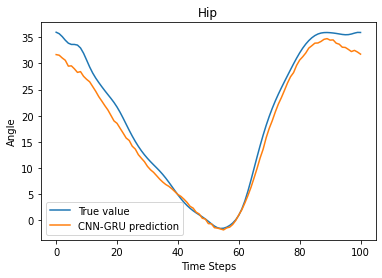

In [65]:
plt.plot(test_y[0], label='True value')
plt.plot(cnn_gru_model.predict(test_x)[0], label='CNN-GRU prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Hip")
plt.legend()
plt.show()

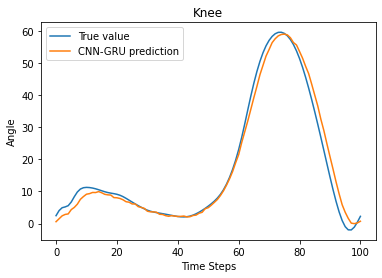

In [66]:
plt.plot(test_y[1], label='True value')
plt.plot(cnn_gru_model.predict(test_x)[1], label='CNN-GRU prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Knee")
plt.legend()
plt.show()

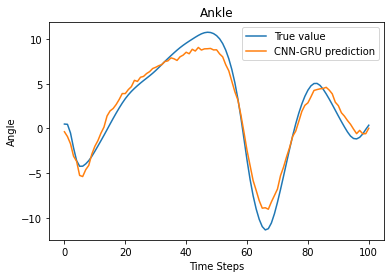

In [67]:
plt.plot(test_y[2], label='True value')
plt.plot(cnn_gru_model.predict(test_x)[2], label='CNN-GRU prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Ankle")
plt.legend()
plt.show()

In [68]:
#for lstm model
#for hip
hip_test_prediction_lstm = lstm_model.predict(hip_test_x)
hip_diff = numpy.abs(hip_test_prediction_lstm - hip_test_y)
hip_mean_lstm = numpy.mean(hip_diff)

knee_test_prediction_lstm = lstm_model.predict(knee_test_x)
knee_diff = numpy.abs(knee_test_prediction_lstm - knee_test_y)
knee_mean_lstm = numpy.mean(knee_diff)

ankle_test_prediction_lstm = lstm_model.predict(ankle_test_x)
ankle_diff = numpy.abs(ankle_test_prediction_lstm - ankle_test_y)
ankle_mean_lstm = numpy.mean(ankle_diff)

hip_mean_lstm, knee_mean_lstm, ankle_mean_lstm

(6.768732311044555, 4.855770914103226, 3.254542418514474)

In [69]:
#for cnn model
hip_test_prediction_cnn = cnn_model.predict(hip_test_x)
hip_diff = numpy.abs(hip_test_prediction_cnn - hip_test_y)
hip_mean_cnn = numpy.mean(hip_diff)

knee_test_prediction_cnn = cnn_model.predict(knee_test_x)
knee_diff = numpy.abs(knee_test_prediction_cnn - knee_test_y)
knee_mean_cnn = numpy.mean(knee_diff)

ankle_test_prediction_cnn = cnn_model.predict(ankle_test_x)
ankle_diff = numpy.abs(ankle_test_prediction_cnn - ankle_test_y)
ankle_mean_cnn = numpy.mean(ankle_diff)

hip_mean_cnn, knee_mean_cnn, ankle_mean_cnn

(9.914342842433015, 12.177142033443396, 11.284760898778485)

In [70]:
#for cnn-gru model
hip_test_prediction_cnn_gru = cnn_gru_model.predict(hip_test_x)
hip_diff = numpy.abs(hip_test_prediction_cnn_gru - hip_test_y)
hip_mean_cnn_gru = numpy.mean(hip_diff)

knee_test_prediction_cnn_gru = cnn_gru_model.predict(knee_test_x)
knee_diff = numpy.abs(knee_test_prediction_cnn_gru - knee_test_y)
knee_mean_cnn_gru = numpy.mean(knee_diff)

ankle_test_prediction_cnn_gru = cnn_gru_model.predict(ankle_test_x)
ankle_diff = numpy.abs(ankle_test_prediction_cnn_gru - ankle_test_y)
ankle_mean_cnn_gru = numpy.mean(ankle_diff)

hip_mean_cnn_gru, knee_mean_cnn_gru, ankle_mean_cnn_gru

(2.745618274168012, 2.919921610844263, 2.096840008324576)

In [71]:
cnn_gru_model2 = build_cnn_gru(101, 7)
cnn_gru_history2 = cnn_gru_model2.fit(train_x, train_y, epochs=300)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 101, 7)]     0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 100, 64)      960         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_8 (MaxPooling1D)  (None, 50, 64)       0           conv1d_8[0][0]                   
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 100, 64)      960         input_2[0][0]                    
____________________________________________________________________________________________

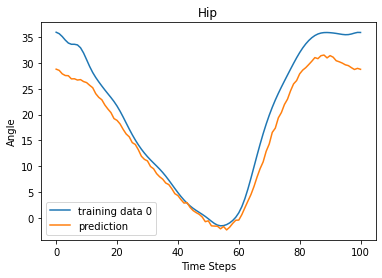

In [72]:
plt.plot(test_y[0], label='training data 0')
plt.plot(cnn_gru_model2.predict(test_x)[0], label='prediction')
plt.title("Hip")
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.legend()
plt.show()

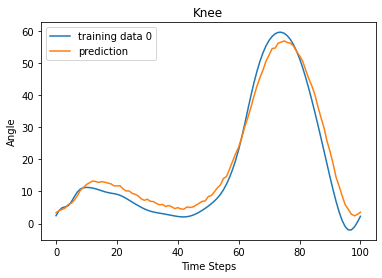

In [73]:
plt.plot(test_y[1], label='training data 0')
plt.plot(cnn_gru_model2.predict(test_x)[1], label='prediction')
plt.title("Knee")
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.legend()
plt.show()

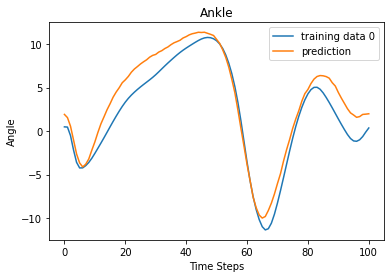

In [74]:
plt.plot(test_y[2], label='training data 0')
plt.plot(cnn_gru_model2.predict(test_x)[2], label='prediction')
plt.title("Ankle")
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.legend()
plt.show()

In [76]:
#for cnn-gru model
hip_test_prediction_cnn_gru = cnn_gru_model2.predict(hip_test_x)
hip_diff = numpy.abs(hip_test_prediction_cnn_gru - hip_test_y)
hip_mean_cnn_gru = numpy.mean(hip_diff)

knee_test_prediction_cnn_gru = cnn_gru_model2.predict(knee_test_x)
knee_diff = numpy.abs(knee_test_prediction_cnn_gru - knee_test_y)
knee_mean_cnn_gru = numpy.mean(knee_diff)

ankle_test_prediction_cnn_gru = cnn_gru_model2.predict(ankle_test_x)
ankle_diff = numpy.abs(ankle_test_prediction_cnn_gru - ankle_test_y)
ankle_mean_cnn_gru = numpy.mean(ankle_diff)

hip_mean_cnn_gru, knee_mean_cnn_gru, ankle_mean_cnn_gru

(4.017410745645007, 3.721009108911395, 2.9240192434507755)

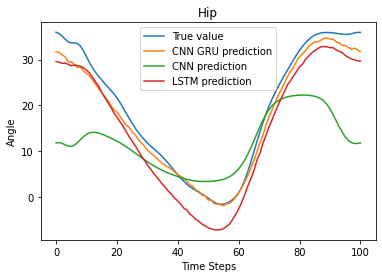

In [77]:
plt.plot(test_y[0], label='True value')
plt.plot(cnn_gru_model.predict(test_x)[0], label='CNN GRU prediction')
plt.plot(cnn_model.predict(test_x)[0], label='CNN prediction')
plt.plot(lstm_model.predict(test_x)[0], label='LSTM prediction')
plt.title("Hip")
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.legend()
plt.show()

In [78]:
person_1_predict_cnn_gru = cnn_gru_model.predict(person1_x)
person_2_predict_cnn_gru = cnn_gru_model.predict(person2_x)
person_1_predict_cnn = cnn_model.predict(person1_x)
person_2_predict_cnn = cnn_model.predict(person2_x)
person_1_predict_lstm = lstm_model.predict(person1_x)
person_2_predict_lstm = lstm_model.predict(person2_x)

In [79]:
person_1_predict_cnn_gru.shape

(24, 101)

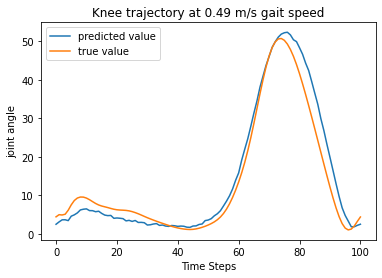

In [80]:
plt.plot(person_1_predict_cnn_gru[1], label="predicted value")
plt.plot(person1_y[1], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Knee trajectory at 0.49 m/s gait speed")
plt.legend()
plt.show()

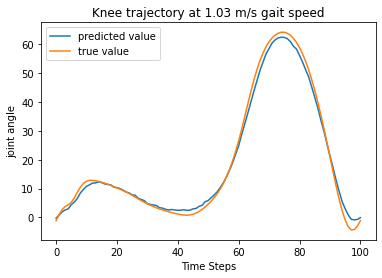

In [81]:
plt.plot(person_1_predict_cnn_gru[10], label="predicted value")
plt.plot(person1_y[10], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Knee trajectory at 1.03 m/s gait speed")
plt.legend()
plt.show()

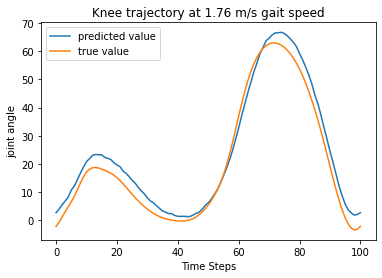

In [82]:
plt.plot(person_1_predict_cnn_gru[22], label="predicted value")
plt.plot(person1_y[22], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Knee trajectory at 1.76 m/s gait speed")
plt.legend()
plt.show()

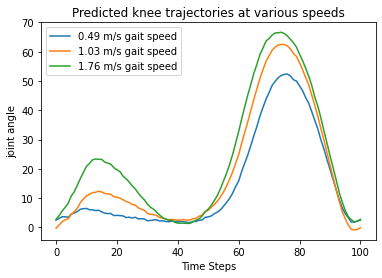

In [83]:
plt.plot(person_1_predict_cnn_gru[1], label="0.49 m/s gait speed")
plt.plot(person_1_predict_cnn_gru[10], label="1.03 m/s gait speed")
plt.plot(person_1_predict_cnn_gru[22], label="1.76 m/s gait speed")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Predicted knee trajectories at various speeds")
plt.legend()
plt.show()

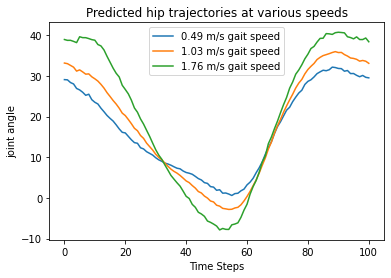

In [84]:
plt.plot(person_1_predict_cnn_gru[0], label="0.49 m/s gait speed")
plt.plot(person_1_predict_cnn_gru[9], label="1.03 m/s gait speed")
plt.plot(person_1_predict_cnn_gru[21], label="1.76 m/s gait speed")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Predicted hip trajectories at various speeds")
plt.legend()
plt.show()

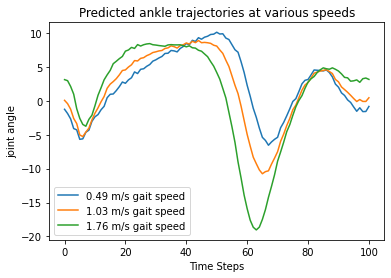

In [85]:
plt.plot(person_1_predict_cnn_gru[2], label="0.49 m/s gait speed")
plt.plot(person_1_predict_cnn_gru[11], label="1.03 m/s gait speed")
plt.plot(person_1_predict_cnn_gru[23], label="1.76 m/s gait speed")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Predicted ankle trajectories at various speeds")
plt.legend()
plt.show()

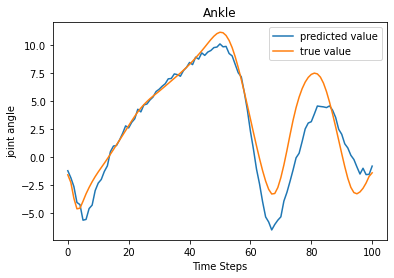

In [86]:
plt.plot(person_1_predict_cnn_gru[2], label="predicted value")
plt.plot(person1_y[2], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Ankle")
plt.legend()
plt.show()

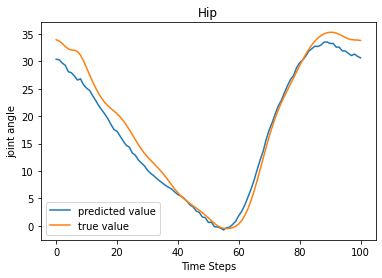

In [87]:
plt.plot(person_1_predict_cnn_gru[3], label="predicted value")
plt.plot(person1_y[3], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Hip")
plt.legend()
plt.show()

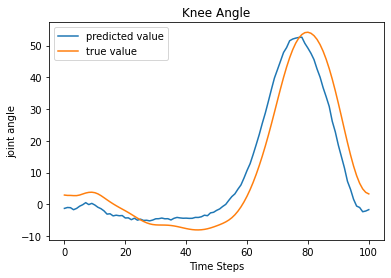

In [89]:
plt.plot(person_2_predict_cnn_gru[1], label="predicted value")
plt.plot(person2_y[1], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Knee Angle")
plt.legend()
plt.show()

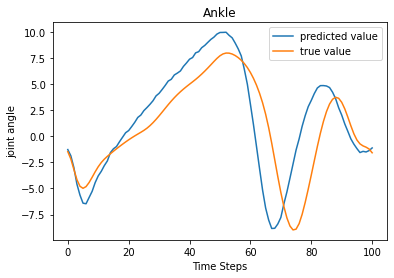

In [90]:
plt.plot(person_2_predict_cnn_gru[2], label="predicted value")
plt.plot(person2_y[2], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Ankle")
plt.legend()
plt.show()

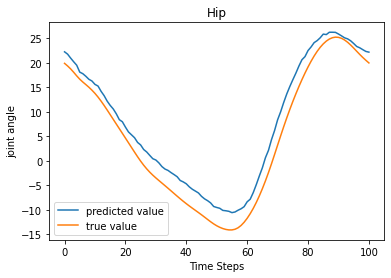

In [91]:
plt.plot(person_2_predict_cnn_gru[3], label="predicted value")
plt.plot(person2_y[3], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Hip")
plt.legend()
plt.show()

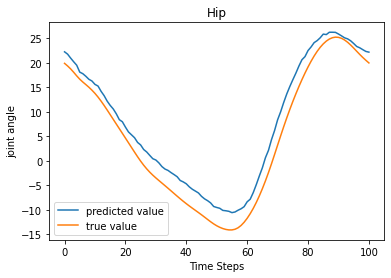

In [93]:
plt.plot(person_2_predict_cnn_gru[3], label="predicted value")
plt.plot(person2_y[3], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Hip")
plt.legend()
plt.show()

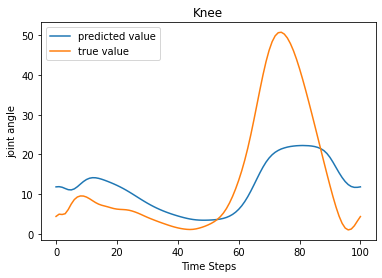

In [94]:
plt.plot(person_1_predict_cnn[1], label="predicted value")
plt.plot(person1_y[1], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Knee")
plt.legend()
plt.show()

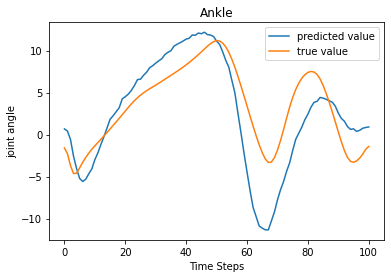

In [95]:
plt.plot(person_1_predict_lstm[2], label="predicted value")
plt.plot(person1_y[2], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Ankle")
plt.legend()
plt.show()

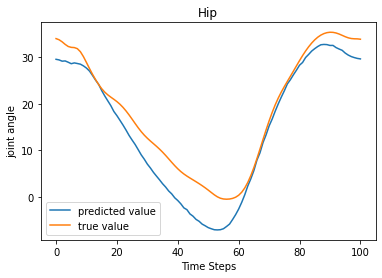

In [96]:
plt.plot(person_1_predict_lstm[3], label="predicted value")
plt.plot(person1_y[3], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Hip")
plt.legend()
plt.show()

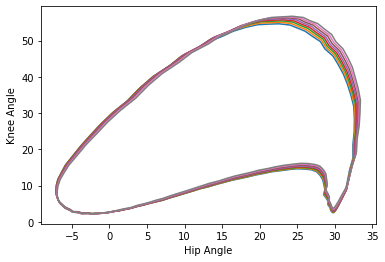

In [97]:
for i in range(0, 24, 3):
  plt.plot(person_1_predict_lstm[i], person_1_predict_lstm[i + 1])
plt.xlabel("Hip Angle")
plt.ylabel("Knee Angle")
plt.show()

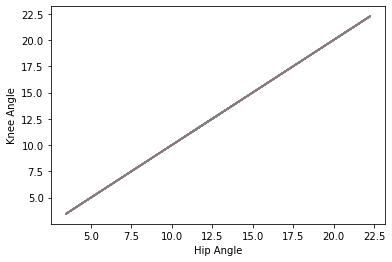

In [101]:
for i in range(0, 24, 3):
  plt.plot(person_1_predict_cnn[i], person_1_predict_cnn[i + 1])
plt.xlabel("Hip Angle")
plt.ylabel("Knee Angle")
plt.show()

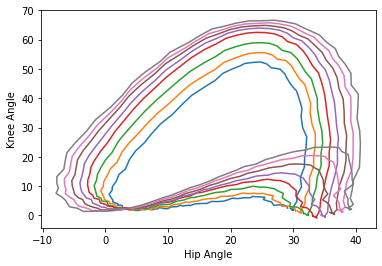

In [102]:
for i in range(0, 24, 3):
  plt.plot(person_1_predict_cnn_gru[i], person_1_predict_cnn_gru[i + 1])
plt.xlabel("Hip Angle")
plt.ylabel("Knee Angle")
plt.show()

In [103]:
dt = 0.5
knee_person_angularVelocity = todot(person_1_predict_lstm[i + 1], dt)

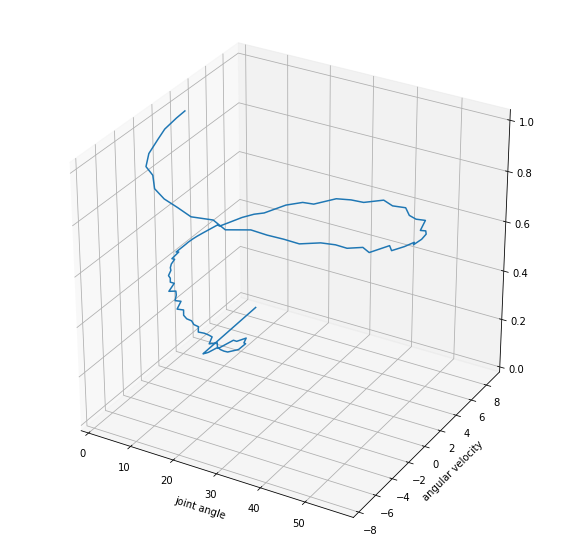

In [104]:
plotDot(person_1_predict_lstm[i + 1], knee_person_angularVelocity, 102)

In [105]:
dt = 0.5
knee_person_angularVelocity = todot(person_1_predict_cnn_gru[i + 1], dt)

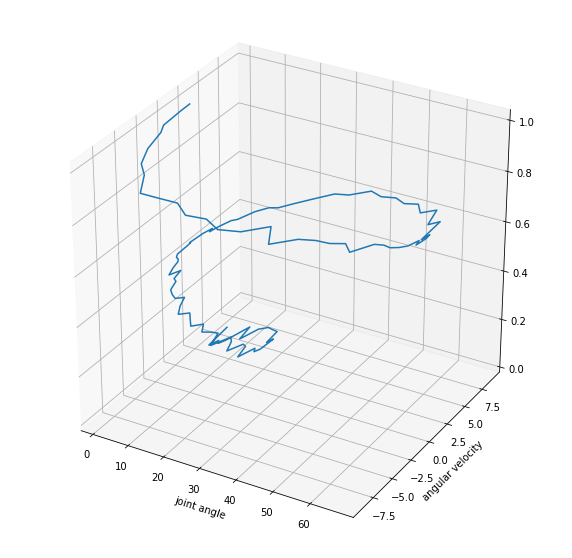

In [106]:
plotDot(person_1_predict_cnn_gru[i + 1], knee_person_angularVelocity, 102)

In [107]:
hip_person_angularVelocity = todot(person_1_predict_lstm[i], dt)

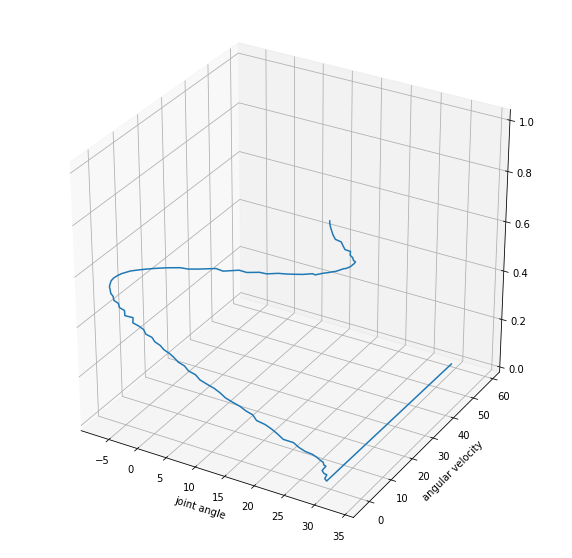

In [108]:
plotDot(person_1_predict_lstm[i], hip_person_angularVelocity, 102)